In [72]:
import os
import glob
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from Bio import PDB  # Biopython for simple PDB parsing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [73]:
# ==== CELL: Plotting Functions ====

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import re

def plot_predictions(y_test, y_pred, title="Actual vs Predicted Fitness Values (Test Set)"):
    """
    Basic scatter plot: actual vs predicted fitness values with y=x line.
    """
    y_true = np.asarray(y_test)
    y_pred = np.asarray(y_pred)

    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k', label='Predicted vs Actual')

    if y_true.size > 0 and y_pred.size > 0:
        min_val = float(min(np.min(y_true), np.min(y_pred)))
        max_val = float(max(np.max(y_true), np.max(y_pred)))
    else:
        min_val, max_val = 0.0, 1.0

    plt.plot([min_val, max_val], [min_val, max_val],
             'r--', lw=2, label='Perfect Prediction Line')
    plt.xlabel("Actual Fitness")
    plt.ylabel("Predicted Fitness")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_predictions1(y_true, y_pred):
    """
    Advanced scatter plot with:
      - color-coded error |y_pred - y_true|
      - y = x line
      - shaded ±1 and ±0.5 regions around y = x
      - RMSD and Pearson R on the plot
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    errors = np.abs(y_pred - y_true)
    colors = errors

    plt.figure(figsize=(7, 7))

    # Scatter with color gradient based on error
    scatter = plt.scatter(y_true, y_pred, c=colors, cmap='coolwarm',
                          alpha=0.7, edgecolors='k')
    plt.colorbar(scatter, label="|Prediction Error| (|y_pred - y_true|)")

    # Identity line
    plt.plot([-2, 9], [-2, 9], 'k-', lw=2, label="y = x")

    x_fill = np.array([-2, 9])

    # ±1 region
    plt.fill_between(x_fill, x_fill - 1, x_fill + 1,
                     color='gray', alpha=0.1, label='±1 Region')
    # ±0.5 region
    plt.fill_between(x_fill, x_fill - 0.5, x_fill + 0.5,
                     color='gray', alpha=0.3, label='±0.5 Region')

    # Metrics
    try:
        rmsd = np.sqrt(mean_squared_error(y_true, y_pred))
    except ValueError:
        rmsd = np.nan
    try:
        pearson_corr, _ = pearsonr(y_true, y_pred)
    except Exception:
        pearson_corr = np.nan

    textstr = f'RMSD: {rmsd:.2f}\nPearson: {pearson_corr:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    plt.text(0.05, 0.95, textstr,
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=props)

    plt.axis("square")
    plt.xlim(-2, 9)
    plt.ylim(-2, 9)
    plt.xlabel("Actual Fitness")
    plt.ylabel("Predicted Fitness")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('predicted_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_bootstrapped_metric_bars(metric_means, metric_cis, metric_names):
    """
    Bar chart for bootstrapped performance metrics with 95% CIs.

    Args:
        metric_means (list of float): Mean value for each metric.
        metric_cis (list of (lower, upper)): 95% CI bounds for each metric.
        metric_names (list of str): Names for each metric.
    """
    num_metrics = len(metric_names)
    y_err = np.zeros((2, num_metrics))
    for i in range(num_metrics):
        lower_ci, upper_ci = metric_cis[i]
        mean_val = metric_means[i]
        y_err[0, i] = mean_val - lower_ci    # below mean
        y_err[1, i] = upper_ci - mean_val    # above mean

    plt.figure(figsize=(10, 6))
    bars = plt.bar(metric_names, metric_means, yerr=y_err,
                   capsize=5, color='skyblue', alpha=0.7)
    plt.ylabel("Metric Value")
    plt.title("Bootstrapped Performance Metrics (95% CIs)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Label each bar with its mean value
    for i, (bar, mean_val) in enumerate(zip(bars, metric_means)):
        yval = bar.get_height()
        text_y_pos = yval + (y_err[1, i] * 0.1)
        plt.text(bar.get_x() + bar.get_width() / 2.0,
                 text_y_pos, f'{mean_val:.3f}',
                 va='bottom', ha='center')

    plt.tight_layout()
    plt.savefig('bootstrapped_metrics_bars.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_predictions_with_confidence(
    y_true,
    mean_preds,
    pred_ci_lower,
    pred_ci_upper,
    title_suffix="Test Set"
):
    """
    Plot actual vs mean predicted values with 95% CI error bars for each point.

    Args:
        y_true (array-like): True target values.
        mean_preds (array-like): Mean predicted values from bootstrap.
        pred_ci_lower (array-like): Lower CI bound for each prediction.
        pred_ci_upper (array-like): Upper CI bound for each prediction.
    """
    y_true = np.asarray(y_true)
    mean_preds = np.asarray(mean_preds)
    pred_ci_lower = np.asarray(pred_ci_lower)
    pred_ci_upper = np.asarray(pred_ci_upper)

    y_err = np.vstack([
        mean_preds - pred_ci_lower,
        pred_ci_upper - mean_preds
    ])

    plt.figure(figsize=(10, 8))
    plt.errorbar(
        y_true,
        mean_preds,
        yerr=y_err,
        fmt='o',
        color='blue',
        ecolor='lightgray',
        elinewidth=1,
        capsize=3,
        alpha=0.6,
        markersize=5,
        label='Mean prediction with 95% CI'
    )

    if y_true.size > 0:
        min_val = float(min(np.min(y_true), np.min(pred_ci_lower)))
        max_val = float(max(np.max(y_true), np.max(pred_ci_upper)))
    else:
        min_val, max_val = 0.0, 1.0

    plt.plot([min_val, max_val], [min_val, max_val],
             'r--', lw=2, label='y = x')

    plt.xlabel("Actual Fitness")
    plt.ylabel("Mean Predicted Fitness (Bootstrap)")
    plt.title(f"Actual vs Mean Predicted Fitness with 95% CIs ({title_suffix})")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    safe_suffix = re.sub(r'[^a-zA-Z0-9_]', '_', title_suffix.lower().replace(' ', '_'))
    plt.savefig(f'predictions_with_confidence_{safe_suffix}.png',
                dpi=300, bbox_inches='tight')
    plt.show()


def plot_correlation_matrix(df, title="Feature Correlation Matrix", annot_threshold=40):
    """
    Heatmap of the correlation matrix for a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        title (str): Title of plot.
        annot_threshold (int): If #features > threshold, turn off annotations.
    """
    if df is None or df.empty or df.shape[1] < 2:
        print("[WARN] Correlation matrix cannot be plotted: DataFrame invalid or < 2 columns.")
        return

    corr_matrix = df.corr(numeric_only=True)
    num_features = len(corr_matrix.columns)

    print(f"[INFO] Computing correlation matrix for DataFrame with shape: {df.shape}")

    fig_width = max(12, num_features * 0.4)
    fig_height = max(10, num_features * 0.35)

    annot_flag = num_features <= annot_threshold
    if not annot_flag:
        print(f"[INFO] Number of features ({num_features}) > {annot_threshold}. "
              f"Turning off annotations for clarity.")

    if num_features > 70:
        annot_font_size = 4
        tick_font_size = 5
    elif num_features > 50:
        annot_font_size = 6
        tick_font_size = 6
    else:
        annot_font_size = 8
        tick_font_size = 8

    plt.figure(figsize=(fig_width, fig_height))
    sns.heatmap(
        corr_matrix,
        annot=annot_flag,
        cmap='coolwarm',
        fmt=".2f",
        linewidths=.5,
        vmin=-1,
        vmax=1,
        annot_kws={"size": annot_font_size}
    )
    plt.title(title, fontsize=14)
    plt.xticks(rotation=60, ha="right", fontsize=tick_font_size)
    plt.yticks(rotation=0, fontsize=tick_font_size)
    plt.tight_layout(pad=1.5)

    try:
        safe_title = re.sub(r'[^a-zA-Z0-9_]', '_', title.lower().replace(" ", "_"))
        filename = f'{safe_title}_correlation_matrix.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"[INFO] Correlation matrix saved as {filename}")
    except Exception as e:
        print(f"[WARN] Could not save correlation matrix plot: {e}")

    plt.show()


def plot_predictions1_with_error_bars(y_true, y_pred, pred_ci_lower, pred_ci_upper):
    """
    Advanced scatter plot with dynamic axis scaling and custom error regions.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error
    from scipy.stats import pearsonr

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    pred_ci_lower = np.asarray(pred_ci_lower)
    pred_ci_upper = np.asarray(pred_ci_upper)

    # --- Calculate dynamic limits based on data ---
    data_min = min(y_true.min(), y_pred.min())
    data_max = max(y_true.max(), y_pred.max())
    
    # Add 10% padding
    diff = data_max - data_min
    if diff == 0: diff = 1.0
    padding = 0.1 * diff
    
    plot_min = data_min - padding
    plot_max = data_max + padding

    errors = np.abs(y_pred - y_true)
    colors = errors

    plt.figure(figsize=(8, 8))

    y_err = np.vstack([
        y_pred - pred_ci_lower,
        pred_ci_upper - y_pred
    ])

    # Errorbar layer
    plt.errorbar(
        y_true, y_pred, yerr=y_err,
        fmt='o',
        color='blue',
        ecolor='lightgray',
        elinewidth=1,
        capsize=3,
        alpha=0.6,
        markersize=5,
        zorder=2
    )

    # Scatter layer with colormap
    scatter_points = plt.scatter(
        y_true, y_pred,
        c=colors,
        cmap='coolwarm',
        alpha=0.7,
        edgecolors='k',
        zorder=3
    )
    plt.colorbar(scatter_points, label="|Prediction Error| (|y_pred - y_true|)")

    # --- UPDATED: Identity line and new shaded regions (±0.3 and ±0.2) ---
    x_fill = np.array([plot_min, plot_max])
    
    plt.plot(x_fill, x_fill, 'k-', lw=2, label="y = x", zorder=4)
    
    # Wider region (±0.3) first with lower opacity
    plt.fill_between(x_fill, x_fill - 0.3, x_fill + 0.3,
                     color='gray', alpha=0.1,
                     label='±0.3 Region', zorder=1)
    
    # Narrower region (±0.2) on top with higher opacity
    plt.fill_between(x_fill, x_fill - 0.2, x_fill + 0.2,
                     color='gray', alpha=0.3,
                     label='±0.2 Region', zorder=1)

    # Metrics
    try:
        rmsd = np.sqrt(mean_squared_error(y_true, y_pred))
    except ValueError:
        rmsd = np.nan
    try:
        pearson_corr, _ = pearsonr(y_true, y_pred)
    except Exception:
        pearson_corr = np.nan

    textstr = f'RMSD: {rmsd:.2f}\nPearson: {pearson_corr:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    plt.text(0.05, 0.95, textstr,
             transform=plt.gca().transAxes,
             fontsize=12,
             verticalalignment='top',
             bbox=props)

    plt.axis("square")
    
    # Set the dynamic limits
    plt.xlim(plot_min, plot_max)
    plt.ylim(plot_min, plot_max)
    
    plt.xlabel("Actual Fitness")
    plt.ylabel("Predicted Fitness")
    plt.grid(True, linestyle='--', alpha=0.7)
    # Update legend to reflect new labels
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('predicted_fixed_with_errors.png', dpi=300, bbox_inches='tight')
    plt.show()

In [74]:
# %%
def parse_hbond_file(hbond_filepath):
    """Extract HBond counts from the file."""
    hbond_counts = []
    with open(hbond_filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            hcount = float(parts[1])
            hbond_counts.append(hcount)
    return hbond_counts


def parse_pdb_file(pdb_filepath):
    """Extracts alpha carbon (CA) coordinates from the file."""
    ca_coordinates = []
    with open(pdb_filepath, 'r') as f:
        for line in f:
            if line.startswith("ATOM") and " CA " in line:
                residue_index = int(line[22:26].strip())
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                ca_coordinates.append((residue_index, x, y, z))
    return ca_coordinates


def compute_graph_features(ca_coordinates):
    """Compute graph-based features (TotalLength, AvgDegree, AvgClustering)."""
    if not ca_coordinates:
        return 0, 0, 0  # If no coordinates, return 0s

    G = nx.Graph()
    coords = np.array([(x, y, z) for _, x, y, z in ca_coordinates])
    residue_nums = [res_idx for res_idx, _, _, _ in ca_coordinates]

    # Build edges if distance < 6.7 Å
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            dist = np.linalg.norm(coords[i] - coords[j])
            if dist < 6.7:
                G.add_edge(residue_nums[i], residue_nums[j], weight=dist)

    if G.number_of_nodes() == 0:
        return 0, 0, 0

    total_length = sum(nx.get_edge_attributes(G, 'weight').values())
    avg_degree = sum(dict(G.degree()).values()) / len(G.nodes)
    avg_clustering = nx.average_clustering(G, weight='weight')
    return total_length, avg_degree, avg_clustering


# ===== Spherical coordinate utilities =====

def _cartesian_to_spherical_batch(rel_coords):
    """
    Convert an array of Cartesian coordinates (N x 3) to spherical:
      r, theta, phi
    Conventions:
      r     : radial distance
      theta : polar angle from +z (0..pi)
      phi   : azimuth angle from +x towards +y (-pi..pi)
    """
    if rel_coords.size == 0:
        return (
            np.array([], dtype=float),
            np.array([], dtype=float),
            np.array([], dtype=float),
        )

    x = rel_coords[:, 0]
    y = rel_coords[:, 1]
    z = rel_coords[:, 2]

    r = np.sqrt(x**2 + y**2 + z**2)

    theta = np.zeros_like(r)
    nonzero = r > 0
    theta[nonzero] = np.arccos(z[nonzero] / r[nonzero])

    phi = np.arctan2(y, x)

    return r, theta, phi


def compute_spherical_features(ca_coordinates, origin=None, prefix="Sph"):
    """
    Compute summary spherical-coordinate features for a set of CA coordinates.

    Args:
        ca_coordinates (list of (res_idx, x, y, z)):
            Coordinates for alpha carbons.
        origin (array-like or None):
            If None, use the mean coordinate as origin.
            Otherwise, a 3-element iterable (x0, y0, z0) for the origin.
        prefix (str):
            Prefix for feature names (e.g., 'SphCenter', 'SphMut').

    Returns:
        dict: {
          f"{prefix}_R_Mean", f"{prefix}_R_Std", f"{prefix}_R_Min", f"{prefix}_R_Max",
          f"{prefix}_Theta_Mean", f"{prefix}_Theta_Std",
          f"{prefix}_Phi_Mean",   f"{prefix}_Phi_Std"
        }
        or {} if no coordinates.
    """
    if not ca_coordinates:
        return {}

    coords = np.array([(x, y, z) for _, x, y, z in ca_coordinates], dtype=float)

    if origin is None:
        origin_vec = coords.mean(axis=0)
    else:
        origin_vec = np.asarray(origin, dtype=float)

    rel_coords = coords - origin_vec
    r_vals, theta_vals, phi_vals = _cartesian_to_spherical_batch(rel_coords)

    if r_vals.size == 0:
        return {}

    features = {
        f"{prefix}_R_Mean": float(r_vals.mean()),
        f"{prefix}_R_Std":  float(r_vals.std(ddof=0)),
        f"{prefix}_R_Min":  float(r_vals.min()),
        f"{prefix}_R_Max":  float(r_vals.max()),
        f"{prefix}_Theta_Mean": float(theta_vals.mean()),
        f"{prefix}_Theta_Std":  float(theta_vals.std(ddof=0)),
        f"{prefix}_Phi_Mean":   float(phi_vals.mean()),
        f"{prefix}_Phi_Std":    float(phi_vals.std(ddof=0)),
    }
    return features


In [75]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

def bootstrap_random_forest(
    X_train,
    y_train,
    X_test,
    y_test,
    n_bootstrap=500,
    base_random_state=42,
    n_estimators=100
):
    """
    Bootstrap the RandomForestRegressor to obtain:
      - CIs for performance metrics (MSE, R², Pearson r)
      - CIs for each individual test prediction.

    Returns:
        results (dict) with keys:
            'metric_names', 'metric_means', 'metric_cis',
            'mean_preds', 'pred_ci_lower', 'pred_ci_upper',
            'all_preds', 'mse_vals', 'r2_vals', 'pearson_vals'
    """
    rng = np.random.default_rng(base_random_state)

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    # Store per-bootstrap predictions on the SAME test set
    all_preds = np.zeros((n_bootstrap, n_test), dtype=float)

    mse_vals = np.zeros(n_bootstrap, dtype=float)
    r2_vals = np.zeros(n_bootstrap, dtype=float)
    pearson_vals = np.zeros(n_bootstrap, dtype=float)

    for b in range(n_bootstrap):
        # --- 1. Resample training set with replacement ---
        sample_idx = rng.integers(0, n_train, size=n_train)
        X_boot = X_train.iloc[sample_idx]
        y_boot = y_train.iloc[sample_idx]

        # --- 2. Train a new RF on the bootstrap sample ---
        model_b = RandomForestRegressor(
            n_estimators=n_estimators,
            random_state=base_random_state + b,
            n_jobs=-1
        )
        model_b.fit(X_boot, y_boot)

        # --- 3. Predict on the fixed test set ---
        preds = model_b.predict(X_test)
        all_preds[b, :] = preds

        # --- 4. Compute metrics on this bootstrap replicate ---
        mse_vals[b] = mean_squared_error(y_test, preds)
        r2_vals[b] = r2_score(y_test, preds)

        # Pearson can sometimes complain if y has zero variance; guard lightly
        try:
            pearson_vals[b] = pearsonr(y_test, preds)[0]
        except Exception:
            pearson_vals[b] = np.nan

    # --- 5. Aggregate metrics: means + 95% CIs (2.5 and 97.5 percentiles) ---
    metric_names = ["MSE", "R²", "Pearson r"]
    metric_arrays = [mse_vals, r2_vals, pearson_vals]

    metric_means = [np.nanmean(arr) for arr in metric_arrays]
    metric_cis = []
    for arr in metric_arrays:
        arr_clean = arr[~np.isnan(arr)]
        lower = float(np.percentile(arr_clean, 2.5))
        upper = float(np.percentile(arr_clean, 97.5))
        metric_cis.append((lower, upper))

    # --- 6. Per-sample prediction intervals ---
    mean_preds = np.mean(all_preds, axis=0)
    pred_ci_lower = np.percentile(all_preds, 2.5, axis=0)
    pred_ci_upper = np.percentile(all_preds, 97.5, axis=0)

    results = {
        "metric_names": metric_names,
        "metric_means": metric_means,
        "metric_cis": metric_cis,
        "mean_preds": mean_preds,
        "pred_ci_lower": pred_ci_lower,
        "pred_ci_upper": pred_ci_upper,
        "all_preds": all_preds,
        "mse_vals": mse_vals,
        "r2_vals": r2_vals,
        "pearson_vals": pearson_vals,
    }

    return results

def parse_freesasa_total_from_sasa_file(path):
    """
    A.sasa / complex.sasa format contains:
      RESULTS (A^2)
      Total   :   12528.40
    Returns float total
    """
    total = None
    with open(path, "r") as f:
        for line in f:
            if line.strip().startswith("Total"):
                m = re.search(r"Total\s*:\s*([0-9]+(?:\.[0-9]+)?)", line)
                if m:
                    total = float(m.group(1))
                    break
    if total is None:
        raise ValueError(f"Could not find 'Total : <num>' in {path}")
    return total


In [76]:
def build_dataset(base_dir):
    mutation_folders = [
        d for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d)) and d != "mutations_without_fitness"
    ]
    data_records = []
    all_hbonds = []

    print(f"[INFO] Processing {len(mutation_folders)} folders in {base_dir}...")

    for folder_name in mutation_folders:
        folder_path = os.path.join(base_dir, folder_name)

        # --- File Paths ---
        complex_sasa_path = os.path.join(folder_path, "complex_sasa.dat")
        achain_sasa_path = os.path.join(folder_path, "a_chain_sasa.dat")
        score_path = os.path.join(folder_path, "target_joint_score.txt")
        wt_aa_path = os.path.join(folder_path, "wt_aa.txt")
        hbond_path = os.path.join(folder_path, "hbonds_per_residue.txt")
        

        pdb_pattern = os.path.join(folder_path, "protein_complex_*.pdb")
        pdb_files = glob.glob(pdb_pattern)

        # --- Validation ---
        if not (os.path.exists(complex_sasa_path) and os.path.exists(achain_sasa_path) and 
                os.path.exists(score_path) and len(pdb_files) > 0):
            continue

        try:
            parts = folder_name.split("_")
            res_index = int(parts[0].replace("res", ""))
            mutated_res = parts[1]

            # Read Scalars
            sasa_bound = float(open(complex_sasa_path).read().strip())
            sasa_unbound = float(open(achain_sasa_path).read().strip())
            fitness = float(open(score_path).read().strip())
            
            wt_res = "UNK"
            if os.path.exists(wt_aa_path):
                wt_res = open(wt_aa_path).read().strip()
            # Read H-Bonds
            hbond_counts = parse_hbond_file(hbond_path) if os.path.exists(hbond_path) else []
            
            # Read PDB
            pdb_file = pdb_files[0]
            ca_coords = parse_pdb_file(pdb_file)
            
            # Derived Features
            total_len, avg_deg, avg_clust = compute_graph_features(ca_coords)
            sph_center = compute_spherical_features(ca_coords, origin=None, prefix="SphCenter")
            
            mut_origin = None
            for r_idx, x, y, z in ca_coords:
                if r_idx == res_index:
                    mut_origin = (x, y, z)
                    break
            sph_mut = compute_spherical_features(ca_coords, origin=mut_origin, prefix="SphMut") if mut_origin else {}

        except Exception as e:
            print(f"[ERROR] {folder_name}: {e}")
            continue

        all_hbonds.append(hbond_counts)

        record = {
            "Folder": folder_name,
            "ResidueIndex": res_index,
            "MutatedResidue": mutated_res,
            "WildTypeResidue": wt_res,
            "SASA_Bound": sasa_bound,
            "SASA_Unbound": sasa_unbound,
            "Fitness": fitness,
            "TotalLength": total_len,
            "AvgDegree": avg_deg,
            "AvgClustering": avg_clust,
        }
        record.update(sph_center)
        if sph_mut: record.update(sph_mut)
        for i, val in enumerate(hbond_counts):
            record[f"HBond_{i+1}"] = val

        data_records.append(record)

    df = pd.DataFrame(data_records)
    
    # Cleanup H-Bonds
    if not df.empty and all_hbonds:
        valid_h = [h for h in all_hbonds if len(h)>0]
        if valid_h:
            max_len = max(len(h) for h in valid_h)
            arr = np.array([h + [0]*(max_len-len(h)) for h in valid_h])
            zero_cols = np.where(np.all(arr == 0, axis=0))[0]
            for idx in zero_cols:
                df.drop(columns=[f"HBond_{idx+1}"], inplace=True, errors='ignore')

    return df

In [77]:
# %%
def main():
    from sklearn.metrics import mean_absolute_error
    # --- Sanity check: plotting functions loaded? ---
    plotting_funcs_to_check = [
        'plot_predictions',
        'plot_predictions1',
        'plot_bootstrapped_metric_bars',
        'plot_predictions_with_confidence',
        'plot_correlation_matrix',
        'plot_predictions1_with_error_bars'
    ]
    for func_name in plotting_funcs_to_check:
        if func_name not in globals() or not callable(globals()[func_name]):
            print(f"[ERROR] Plotting function '{func_name}' not found. Run the plotting cell first.")
            return

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.utils import resample  # in case not imported globally

    # --- Data loading and preprocessing ---
    TARGET_MAX_INDEX = 101
    base_dir = "Sumo_data/sumo_data"
    print(f"[INFO] Starting dataset build from base directory: {base_dir}")
    try:
        df = build_dataset(base_dir)
    except NameError:
        print("[ERROR] `build_dataset` function not found. Please ensure it's defined.")
        return

    if df.empty:
        print("[ERROR] Empty DataFrame from build_dataset. Exiting.")
        return

    if 'Fitness' not in df.columns:
        print("[ERROR] 'Fitness' column missing. Exiting.")
        return

    # Drop rows without Fitness
    df.dropna(subset=['Fitness'], inplace=True)

    # --- One-hot encode residues ---
    categorical_cols = ['MutatedResidue', 'WildTypeResidue']
    if not all(col in df.columns for col in categorical_cols):
        print("[ERROR] Missing categorical columns for OHE. Exiting.")
        return

    df = pd.get_dummies(df, columns=categorical_cols,
                        prefix=['MutRes', 'WT'], dummy_na=False)

    # --- ΔSASA features ---
    delta_sasa_features = []
    for k in range(1, TARGET_MAX_INDEX + 1):
        bound_col = f"FreeSASA_Bound_{k}"
        unbound_col = f"FreeSASA_Unbound_{k}"
        delta_col = f"DeltaSASA_{k}"
        if bound_col in df.columns and unbound_col in df.columns:
            df[delta_col] = df[bound_col] - df[unbound_col]
            delta_sasa_features.append(delta_col)

    # --- Feature groups ---
    base_features = [
        "ResidueIndex", 
        "SASA_Bound", 
        "SASA_Unbound",
        "Delta_SASA",
        "TotalLength", 
        "AvgDegree", 
        "AvgClustering"
    ]

    degree_features = sorted(
        [col for col in df.columns if col.startswith("Degree_Res_")],
        key=lambda x: int(x.split('_')[-1])
    )
    clustering_features = sorted(
        [col for col in df.columns if col.startswith("Clustering_Res_")],
        key=lambda x: int(x.split('_')[-1])
    )
    freesasa_unbound_features = sorted(
        [col for col in df.columns if col.startswith("FreeSASA_Unbound_")],
        key=lambda x: int(x.split('_')[-1])
    )
    freesasa_bound_features = sorted(
        [col for col in df.columns if col.startswith("FreeSASA_Bound_")],
        key=lambda x: int(x.split('_')[-1])
    )
    hbond_cols = sorted(
        [c for c in df.columns if c.startswith("HBond_")],
        key=lambda x: int(x.split('_')[-1])
    )

    # NEW: spherical-coordinate features (both center-origin and mutated-residue-origin)
    spherical_features = sorted(
        [c for c in df.columns if c.startswith("Sph")],
        key=lambda x: x
    )

    mut_dummy_cols = sorted([col for col in df.columns if col.startswith('MutRes_')])
    wt_dummy_cols = sorted([col for col in df.columns if col.startswith('WT_')])

    feature_cols = (
        base_features
        + hbond_cols
        + degree_features
        + clustering_features
        + freesasa_unbound_features
        + freesasa_bound_features
        + delta_sasa_features
        + spherical_features
        + mut_dummy_cols
        + wt_dummy_cols
    )

    final_feature_cols = [
        col for col in feature_cols
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col])
    ]

    if not final_feature_cols:
        print("[ERROR] No valid features found. Exiting.")
        return

    X = df[final_feature_cols]
    y = df['Fitness']

    if X.isnull().values.any():
        print("[ERROR] NaNs detected in X. Exiting.")
        return

    # --- Train / Test split ---
    print("[INFO] Splitting data into training and testing sets (80/20)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"   - Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"   - Testing set shape:  X_test: {X_test.shape}, y_test: {y_test.shape}")

    # --- Base RandomForest model (no GridSearch, just fixed hyperparams) ---
    print("\n[INFO] Training RandomForestRegressor model...")
    rf_params = dict(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1
    )
    rf_model = RandomForestRegressor(random_state=42, **rf_params)
    rf_model.fit(X_train, y_train)

    # --- Base model evaluation (no bootstrap yet) ---
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_pearson, _ = pearsonr(y_train, y_pred_train)
    test_pearson, _ = pearsonr(y_test, y_pred_test)

    print("\n--- Model Performance (RandomForestRegressor) ---")
    print(f"Metric         | Training Set | Test Set")
    print(f"---------------|--------------|-----------")
    print(f"MSE            | {train_mse:<12.4f} | {test_mse:<9.4f}")
    print(f"MAE            | {train_mae:<12.4f} | {test_mae:<9.4f}")
    print(f"R²             | {train_r2:<12.4f} | {test_r2:<9.4f}")
    print(f"Pearson R      | {train_pearson:<12.4f} | {test_pearson:<9.4f}")

    # Simple scatter of test predictions
    try:
        plot_predictions(y_test, y_pred_test)
    except Exception as e:
        print(f"[ERROR] plot_predictions failed: {e}")

    # ======================================================================
    # BOOTSTRAP SECTION 1: Test-set metrics + per-sample prediction intervals
    # ======================================================================
    print("\n[INFO] Starting bootstrapping for performance metrics on test set...")

    n_bootstrap = 100
    n_test = len(y_test)

    boot_test_preds = np.zeros((n_bootstrap, n_test))
    boot_test_mses = np.zeros(n_bootstrap)
    boot_test_maes = np.zeros(n_bootstrap)
    boot_test_r2s = np.zeros(n_bootstrap)
    boot_test_pearsons = np.zeros(n_bootstrap)

    y_test_np = y_test.values

    for i in range(n_bootstrap):
        # Resample train set with replacement
        X_boot, y_boot = resample(X_train, y_train, random_state=i)

        model = RandomForestRegressor(random_state=42 + i, **rf_params)
        model.fit(X_boot, y_boot)

        y_pred_bs = model.predict(X_test)
        boot_test_preds[i, :] = y_pred_bs

        boot_test_mses[i] = mean_squared_error(y_test_np, y_pred_bs)
        boot_test_maes[i] = mean_absolute_error(y_test_np, y_pred_bs)
        boot_test_r2s[i] = r2_score(y_test_np, y_pred_bs)
        r_bs, _ = pearsonr(y_test_np, y_pred_bs)
        boot_test_pearsons[i] = r_bs

    # --- Per-sample prediction CIs on TEST set ---
    mean_boot_preds_test = np.mean(boot_test_preds, axis=0)
    ci_lower_test = np.percentile(boot_test_preds, 2.5, axis=0)
    ci_upper_test = np.percentile(boot_test_preds, 97.5, axis=0)

    # 1) Simple CI scatter vs y=x
    try:
        plot_predictions_with_confidence(
            y_true=y_test_np,
            mean_preds=mean_boot_preds_test,
            pred_ci_lower=ci_lower_test,
            pred_ci_upper=ci_upper_test,
            title_suffix="Test Set (Bootstrap, RF)"
        )
    except Exception as e:
        print(f"[ERROR] plot_predictions_with_confidence failed: {e}")

    # 2) Fancy shaded plot with error bars
    try:
        plot_predictions1_with_error_bars(
            y_true=y_test_np,
            y_pred=mean_boot_preds_test,
            pred_ci_lower=ci_lower_test,
            pred_ci_upper=ci_upper_test
        )
    except Exception as e:
        print(f"[ERROR] plot_predictions1_with_error_bars on test set failed: {e}")

    # --- Aggregate metric CIs and plot bars ---
    metric_names = ["MSE", "MAE", "R²", "Pearson R"]
    metric_means = [
        float(np.mean(boot_test_mses)),
        float(np.mean(boot_test_maes)),
        float(np.mean(boot_test_r2s)),
        float(np.mean(boot_test_pearsons))
    ]

    mse_ci = np.percentile(boot_test_mses, [2.5, 97.5])
    mae_ci = np.percentile(boot_test_maes, [2.5, 97.5])
    r2_ci = np.percentile(boot_test_r2s, [2.5, 97.5])
    pearson_ci = np.percentile(boot_test_pearsons, [2.5, 97.5])

    metric_cis = [
        (float(mse_ci[0]), float(mse_ci[1])),
        (float(mae_ci[0]), float(mae_ci[1])),
        (float(r2_ci[0]), float(r2_ci[1])),
        (float(pearson_ci[0]), float(pearson_ci[1]))
    ]

    print("\n[RESULT] Bootstrapped metrics (mean ± 95% CI):")
    for name, mean_val, (ci_low, ci_high) in zip(metric_names, metric_means, metric_cis):
        print(f"  {name}: {mean_val:.4f} (95% CI: [{ci_low:.4f}, {ci_high:.4f}])")

    try:
        plot_bootstrapped_metric_bars(metric_means, metric_cis, metric_names)
    except Exception as e:
        print(f"[ERROR] plot_bootstrapped_metric_bars failed: {e}")

    # ======================================================================
    # BOOTSTRAP SECTION 2: Predictions on ALL data (optional)
    # ======================================================================
    print("\n[INFO] Starting bootstrapping for full dataset predictions...")
    all_boot_preds_on_all = np.zeros((n_bootstrap, len(X)))

    for i in range(n_bootstrap):
        X_boot, y_boot = resample(X_train, y_train, random_state=100 + i)
        model = RandomForestRegressor(random_state=142 + i, **rf_params)
        model.fit(X_boot, y_boot)
        all_boot_preds_on_all[i, :] = model.predict(X)

    mean_boot_preds_all = np.mean(all_boot_preds_on_all, axis=0)
    ci_lower_all = np.percentile(all_boot_preds_on_all, 2.5, axis=0)
    ci_upper_all = np.percentile(all_boot_preds_on_all, 97.5, axis=0)

    try:
        plot_predictions1_with_error_bars(
            y_true=y.values,
            y_pred=mean_boot_preds_all,
            pred_ci_lower=ci_lower_all,
            pred_ci_upper=ci_upper_all
        )
    except Exception as e:
        print(f"[ERROR] plot_predictions1_with_error_bars on full data failed: {e}")

    print("\n[INFO] Main function execution complete.")


[INFO] Starting dataset build from base directory: Sumo_data/sumo_data
[INFO] Processing 1919 folders in Sumo_data/sumo_data...
[INFO] Splitting data into training and testing sets (80/20)...
   - Training set shape: X_train: (1535, 156), y_train: (1535,)
   - Testing set shape:  X_test: (384, 156), y_test: (384,)

[INFO] Training RandomForestRegressor model...

--- Model Performance (RandomForestRegressor) ---
Metric         | Training Set | Test Set
---------------|--------------|-----------
MSE            | 0.0110       | 0.0692   
MAE            | 0.0806       | 0.2059   
R²             | 0.9063       | 0.4089   
Pearson R      | 0.9759       | 0.6537   


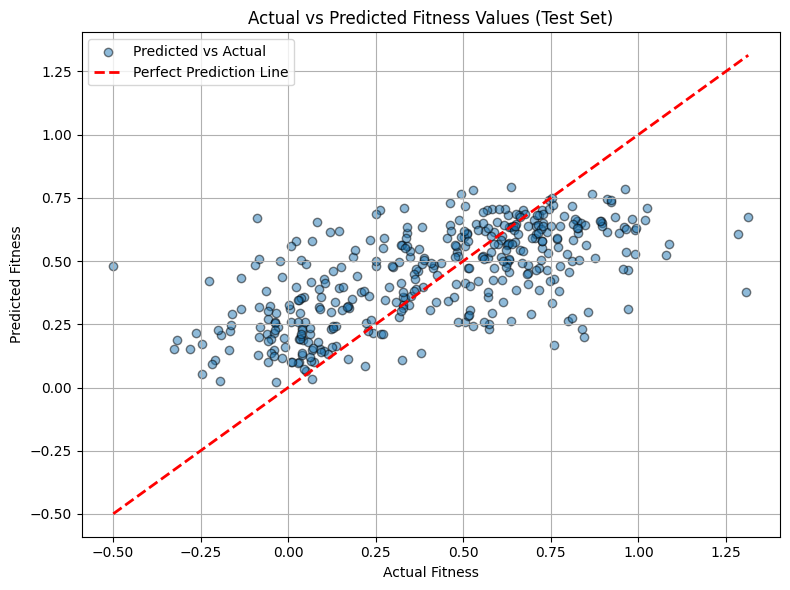


[INFO] Starting bootstrapping for performance metrics on test set...


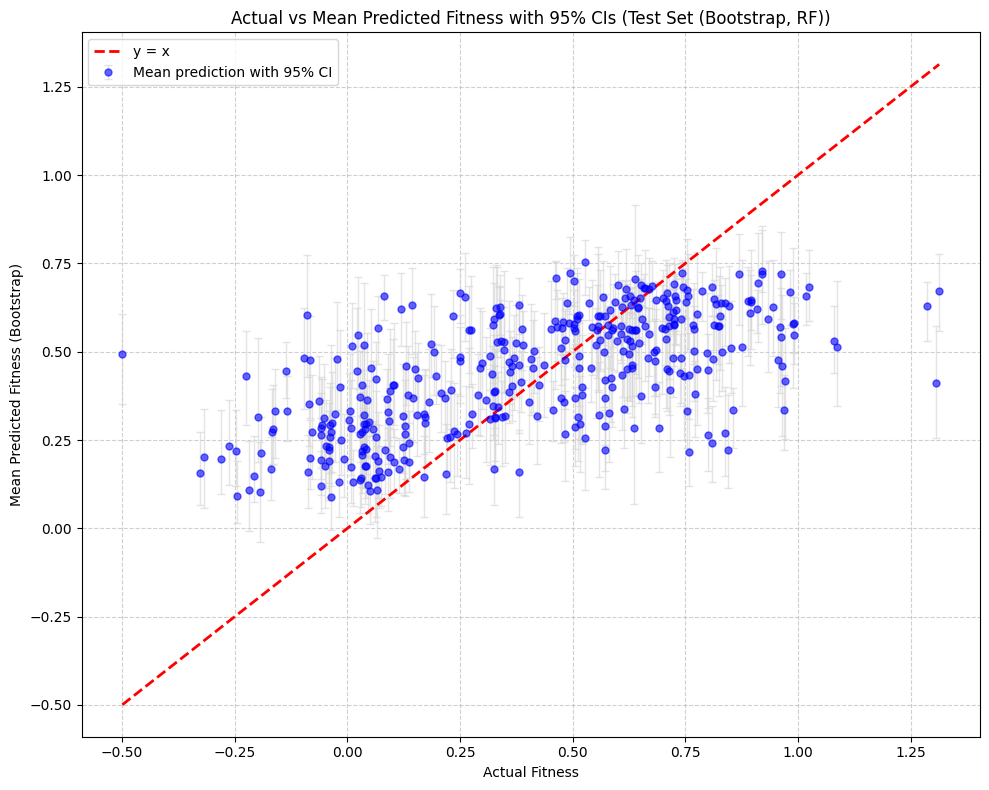

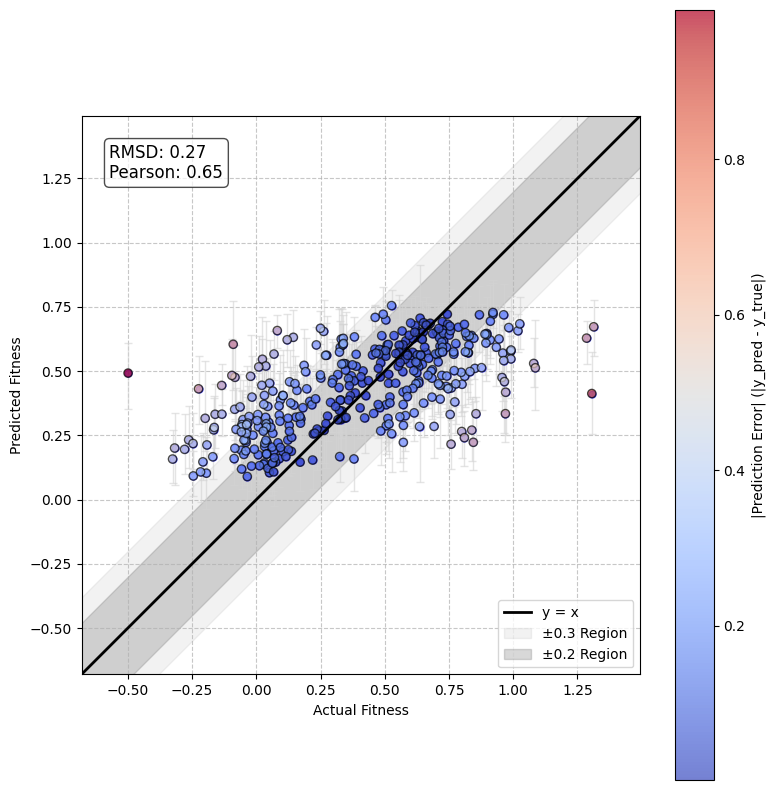


[RESULT] Bootstrapped metrics (mean ± 95% CI):
  MSE: 0.0762 (95% CI: [0.0713, 0.0813])
  MAE: 0.2182 (95% CI: [0.2092, 0.2278])
  R²: 0.3487 (95% CI: [0.3052, 0.3903])
  Pearson R: 0.6034 (95% CI: [0.5680, 0.6424])


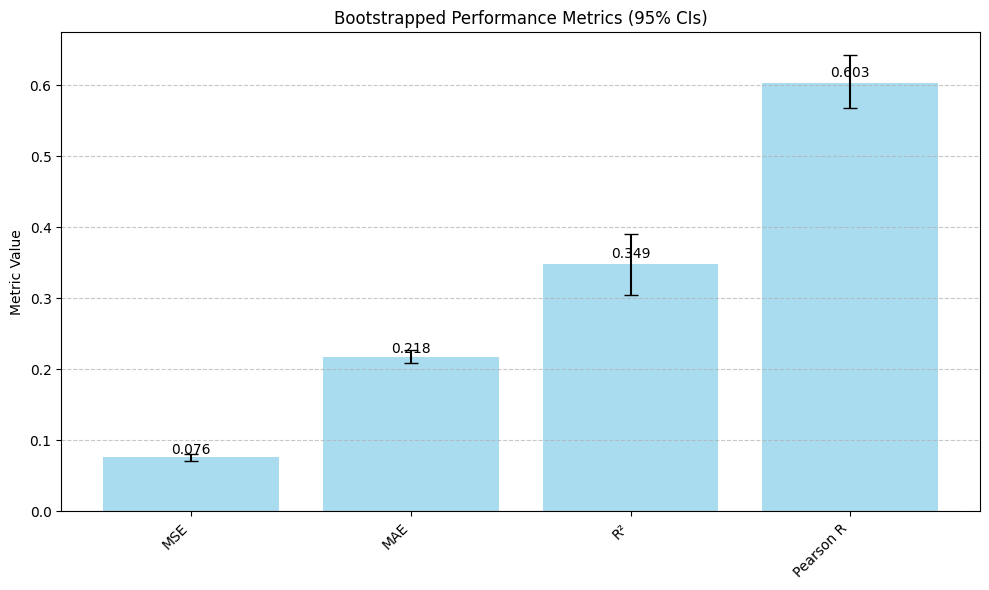


[INFO] Starting bootstrapping for full dataset predictions...


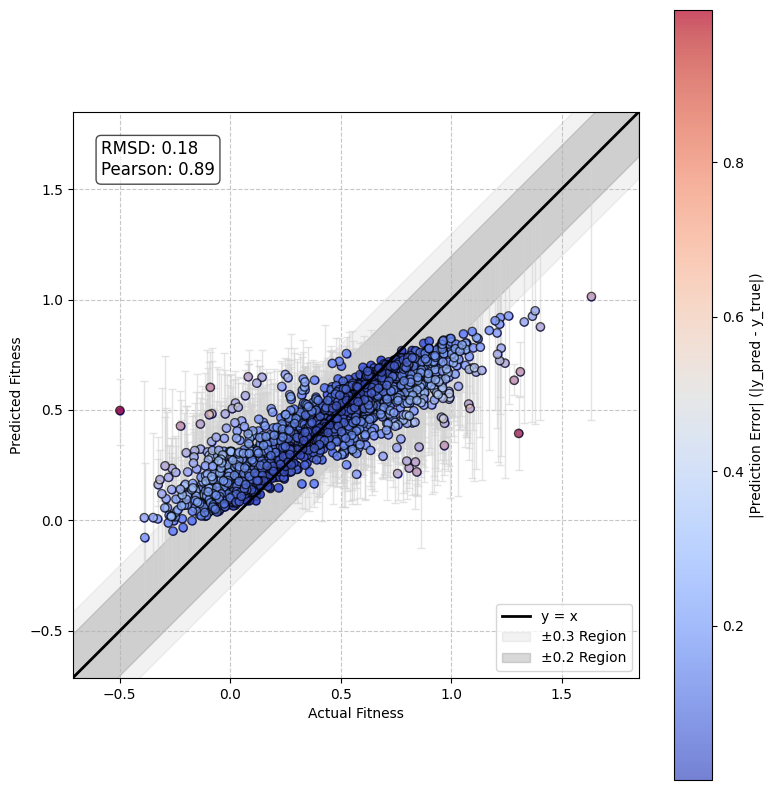


[INFO] Main function execution complete.


In [78]:
if __name__ == "__main__":
    main()
